In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from pathlib import Path
from sklearn import linear_model as LM

plt.rcParams['figure.dpi']     = 100
plt.rcParams['figure.figsize'] = 10,7
plt.rcParams['axes.prop_cycle'] = cycler('color', ['cadetblue','orangered','gold', 'navy'])

In [6]:
mortality_data = pd.read_csv(Path('dane\HLTH_CD_ARO.csv'))

mortality_data

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,icd10,resid,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2011,39758.0,NaN
1,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2012,41803.0,NaN
2,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2013,41378.0,NaN
3,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2014,40662.0,NaN
4,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2015,43159.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4769935,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2014,995.0,NaN
4769936,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2015,1020.0,NaN
4769937,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2016,936.0,NaN
4769938,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2017,1021.0,NaN


In [7]:
mortality_data.drop(['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'OBS_FLAG'], axis = 1, inplace=True)


In [8]:
mortality_data_PL = mortality_data[(mortality_data['geo']=='PL') & (mortality_data['icd10'] == 'A-R_V-Y') & (mortality_data['age'] == 'TOTAL') & (mortality_data['sex'] == 'T') & (mortality_data['resid'] == 'TOT_IN')]
mortality_data_PL

,sex,age,icd10,resid,geo,TIME_PERIOD,OBS_VALUE
3154152,T,TOTAL,A-R_V-Y,TOT_IN,PL,2011,376150.0
3154153,T,TOTAL,A-R_V-Y,TOT_IN,PL,2012,385456.0
3154154,T,TOTAL,A-R_V-Y,TOT_IN,PL,2013,387988.0
3154155,T,TOTAL,A-R_V-Y,TOT_IN,PL,2014,377182.0
3154156,T,TOTAL,A-R_V-Y,TOT_IN,PL,2015,395578.0
3154157,T,TOTAL,A-R_V-Y,TOT_IN,PL,2016,388677.0
3154158,T,TOTAL,A-R_V-Y,TOT_IN,PL,2017,403559.0
3154159,T,TOTAL,A-R_V-Y,TOT_IN,PL,2018,414941.0
3154160,T,TOTAL,A-R_V-Y,TOT_IN,PL,2019,410564.0
3154161,T,TOTAL,A-R_V-Y,TOT_IN,PL,2020,478008.0


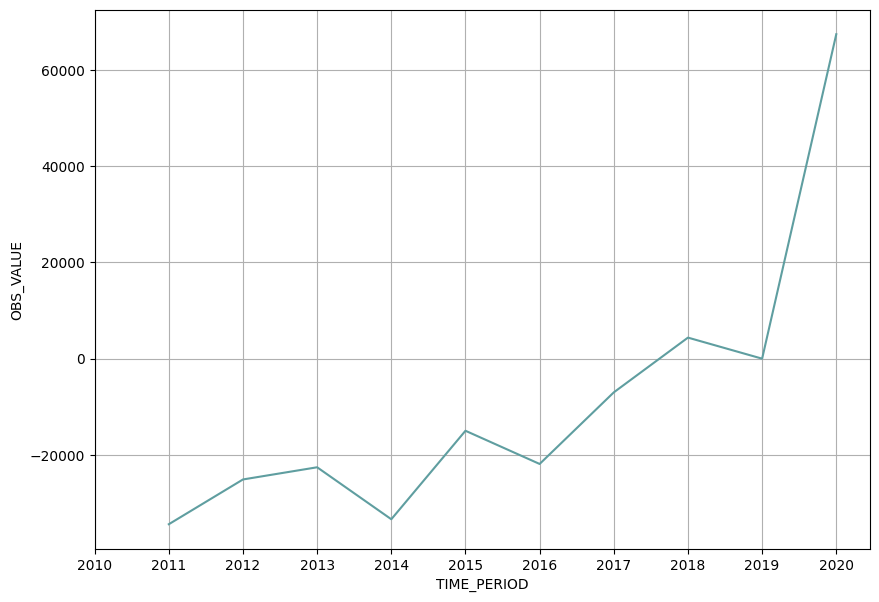

In [13]:
sns.lineplot(data = mortality_data_PL, x = 'TIME_PERIOD', y = mortality_data_PL['OBS_VALUE']-mortality_data_PL.loc[3154160,'OBS_VALUE'])
plt.xticks([x for x in range(2010,2021)])
plt.grid('both')
plt.show()

In [22]:
LM_reg = LM.LinearRegression()
LM_reg.fit([ [mortality_data_PL['TIME_PERIOD']], y = mortality_data_PL['OBS_VALUE'].values])

TypeError: LinearRegression.fit() got an unexpected keyword argument 'x'